In [85]:
import torch
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd # data manager
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from pathlib import Path # saving pytorch model
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### 0. Computer Vision libaries in PyTorch

* `torchvision` -base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset 

In [86]:
import torchvision
#from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# check versions
print(torch.__version__)
print(torchvision.__version__)

2.1.1+cu121
0.16.1


### 1. Getting a dataset

The dataset we'll be using is FashionMNIST.

In [87]:
# Setup training data
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root="data",# where to download data to?
    train=True, # do we want the training dataset?
    download=True, # do we want to download yes/no?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data?
    target_transform=None # how do we want to transform the labels/targets?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

#### 1.1 Check input and output shapes & properties of data

In [88]:
len(train_data),len(test_data)

(60000, 10000)

In [89]:
image, label = train_data[0]
# image : torch.Tensor
# label : int

In [90]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [91]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [92]:
# check the shape of our image at position 0
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")
# color channels has single color channel since it's gray scale.

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


#### 1.2 Visualizing our data

Text(0.5, 1.0, '9')

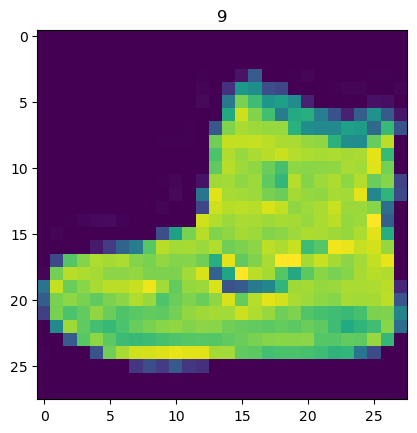

In [93]:
plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

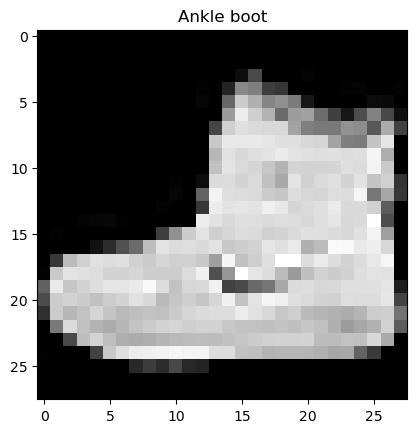

In [94]:
plt.imshow(image.squeeze(),cmap="gray")
plt.title(class_names[label])

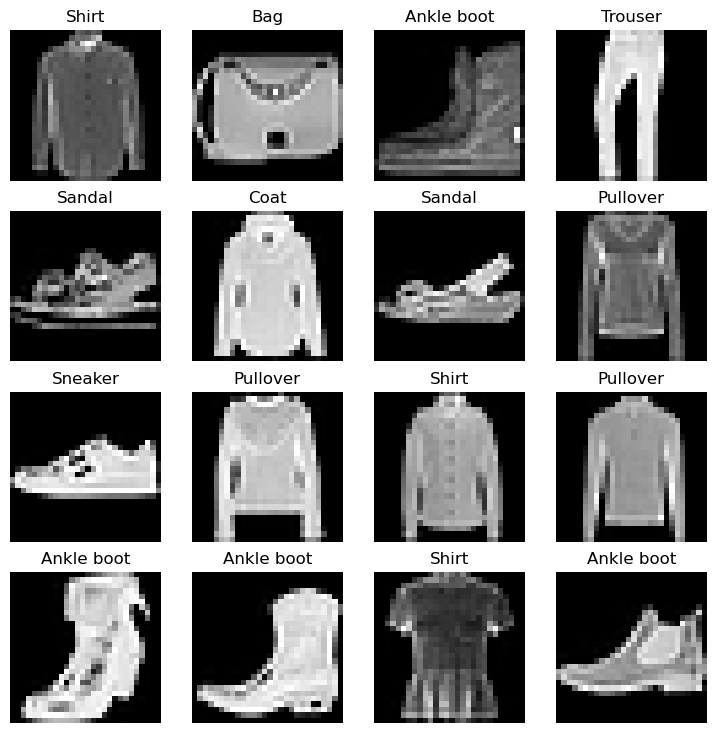

In [95]:
# Plot more images
#torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,cols = 4,4
for i in range(1,rows*cols+1):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    #print(random_idx)
    img, label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

Do you think these items of clothing (images) could be modeled with pure linear lines?
Or do you thinkd we'll need non-linearities?


### 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into Python iterable.

More specifically, we want to turn our data into batches (or mini-batches).

Why would we do this?

1. It is more computationally efficient, as in, your computing hardward may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).
2. It gives our neural network more chances to updata its gradients per epoch.


In [96]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) # keep model from learning data order

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x12a930eefd0>,
 <torch.utils.data.dataloader.DataLoader at 0x12a9da6a010>)

In [97]:
# Let's check out what we've created
print(f"DateLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloaderL {len(test_dataloader)} batches of {BATCH_SIZE}...")

DateLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000012A930EEFD0>, <torch.utils.data.dataloader.DataLoader object at 0x0000012A9DA6A010>)
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloaderL 313 batches of 32...


In [98]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


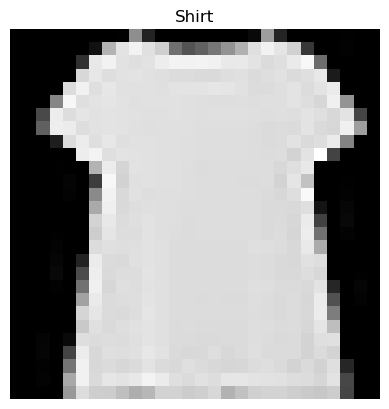

In [103]:
# Show a sample
#torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch),size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(),cmap="gray")
plt.title(class_name[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

### 3. Model 0: Build a basline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [116]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: { output.shape} -> [color_channels, height*width]")


Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [117]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

    def forward(self,x):
        return self.layer_stack(x)


In [121]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=28*28, # this is 28*28
    hidden_units = 10, # how many units in the hidden layer
    output_shape = len(class_name) # one for every class
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [122]:
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [123]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

#### 3.1 Setup loss, optimizer and evaluate metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss`.
* Optimizer - our optimizer `torch.optim.SGD()`
* Evaluation metric - since we're working on a classification problem, let's use accuracy as our evaluation metric.

In [126]:
import requests
from pathlib import Path

# Download helper functions from Learn Pytorch repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download...")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
    

helper_functions.py already exists, skipping download...


In [128]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

#### 3.2 Creating a function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs

In [135]:
# timer function
from timeit import default_timer as timer
def print_train_time(start:float,
                     end:float,
                     device: torch.device=None):
    """Prints difference between start and end time."""
    total_time = end-start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [136]:
start_time = timer()
# some code
end_time = timer()
print_train_time(start = start_time,end=end_time,device="cpu")

Train time on cpu: 0.000 seconds


5.549995694309473e-05

#### 3.3 Create a training loop and training a model on batches of data...

Highlight that the optimizer will updata a model's parameter per batch rather then once an epoch.

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happenin'.
5. Time it all(for fun).

In [141]:
# Import tqdm for progress bar
from tqdm.auto import tqdm


# Set the seed and start the times
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs=3

# Create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"\nEpoch: {epoch}\n------")

    ### Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # Print out what's happenin'
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")


    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X_test)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y_test)

            # 3. Calculate accuracy
            test_acc += accuracy_fn(y_true=y_test,
                                    y_pred=test_pred.argmax(dim=1))
        
        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)

        # Calculate the test acc average per batch
        test_acc /= len(test_dataloader)
        
    # Print out what's happenin'
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]


Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4440 | Test loss: 0.4651, Test acc: 83.65%

Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4366 | Test loss: 0.4645, Test acc: 83.89%

Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4305 | Test loss: 0.4659, Test acc: 83.93%
Train time on cpu: 126.371 seconds


In [ ]:
### 4. Make predictions and get Model 0 results

In [187]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device:torch.device = device):
    """Return a dictionary containing the results of model predicting on data_loader."""
    loss, acc = 0,0
    model = model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make our data device agnostic
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name":model.__class__.__name__, # only works when model was created with a class
            "model_loss":loss.item(),
            "model_acc":acc}

# Calculate model_0 result on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4659360349178314,
 'model_acc': 83.92571884984025}

### 5. Setup device agnostic-code (for using a GPU if there is one)

In [144]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 6. Model 1: Building a better model with non-linearity

We learn about the power of non-linearity in notebook 02

In [180]:
# Create a model with linear and non-linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x:torch.Tensor):
        return self.layer_stack(x)

In [181]:
# Create an instancee of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=28*28,
                              hidden_units=10,
                              output_shape=len(class_name)).to(device) 
                                    # send to the GPU if it's available

next(model_1.parameters()).device

device(type='cuda', index=0)

In [182]:
#### 6.1 Setup loss, optimizer and evaluation metrics
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # measure how wrong our model is
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)# tries to update our model's parameters to reduce the loss

#### 6.2 Functionizing training and evaluation/test loops
Let;s create a function for:
* training loop - `train_step()`
* testing loop - `test_step()`

In [183]:
def train_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):
    """Performs a training with model trying to learn on data_loader."""
    train_loss, train_acc = 0, 0
    
    # Put model into training mode
    model.train()

    # Add a loop to loop through the training batches
    for batch, (X,y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        train_acc += accuracy_fn(y_true=y, # accumulate train loss
                                 y_pred=y_pred.argmax(dim=1))
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # Print out what's happenin'
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")


    # Divide total train loss and accuracy by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [184]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """Performs a testing loop step on model going over data_loader."""
    test_loss, test_acc = 0,0

    # Put the model in eval mode
    model.eval()

    # Turn on inference mode context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send the data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate the loss/acc
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1)) #go from logits -> prediction labels

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

In [185]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_GPU = timer()

# Set epochs
epochs = 3

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f"\nEpoch: {epoch}\n-----------")
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

train_time_end_on_GPU = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_GPU,
                                            end=train_time_end_on_GPU,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch: 0
-----------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 1.09199 | Train acc: 61.34%
Test loss: 0.95636 | Test acc: 65.00%

Epoch: 1
-----------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.78101 | Train acc: 71.93%
Test loss: 0.72227 | Test acc: 73.91%

Epoch: 2
-----------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.67027 | Train acc: 75.94%
Test loss: 0.68500 | Test acc: 75.02%
Train time on cuda: 65.506 seconds


#### **Note**: Sometimes, depending on your data/hardware you might find that your modle trains faster on CPU than GPU.

Why is this?

1. It could be that the overhead for copying data/model to and from the GPU outweight the compute benefits offered by the GPU.
2. The hardward you're using has a better CPU in terms compute capability than the GPU.

In [188]:
# Get model_1 result dictionary
model_1_results = eval_model(model=model_1,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

### Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also known as ConvNets.

CNN's are known for their capabilities to find patterns in visual data.

To find out what's happening inside CNN, go check CNN explaner website.

In [243]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates the TinyVGG
    model from CNN explainer website.
    """
    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
                                nn.Conv2d(in_channels=input_shape,
                                          out_channels=hidden_units,
                                          kernel_size=3,
                                          stride=1,
                                          padding=1), # values we can set ourselves in our NN's are called hyperparameters
                                nn.ReLU(),
                                nn.Conv2d(in_channels=hidden_units,
                                          out_channels=hidden_units,
                                          kernel_size=3,
                                          stride=1,
                                          padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2))
        
        self.conv_block_2 = nn.Sequential(
                                nn.Conv2d(in_channels=hidden_units,
                                          out_channels=hidden_units,
                                          kernel_size=3,
                                          stride=1,
                                          padding=1),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=hidden_units,
                                          out_channels=hidden_units,
                                          kernel_size=3,
                                          stride=1,
                                          padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2))
                    
        self.classifier = nn.Sequential(
                              nn.Flatten(),
                              nn.Linear(in_features=hidden_units*7*7, # there's a trick to calculating this
                                        out_features=output_shape))

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        #print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        return x


In [244]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_name)).to(device)

model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

#### 7.1 Stepping through `nn.Conv2d()`

In [245]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32,3,64,64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [246]:
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=(3,3),
                       stride=1,
                       padding=1)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image)  # unsqueeze(dim=0) -> add batch size dimension

conv_output.shape,conv_output

(torch.Size([10, 64, 64]),
 tensor([[[ 1.6446e-01, -6.2518e-01, -7.7713e-01,  ..., -3.2504e-01,
           -3.1604e-01,  4.5352e-01],
          [ 3.5455e-01, -2.8778e-01, -6.0596e-02,  ...,  6.6224e-01,
           -2.3216e-01,  7.7080e-01],
          [-4.5420e-02, -9.8911e-01, -4.0099e-01,  ..., -1.8552e-01,
           -5.7622e-01,  4.2301e-01],
          ...,
          [ 2.9288e-01, -1.4512e-01, -1.1566e-01,  ..., -3.6626e-01,
            3.5645e-01,  2.8384e-01],
          [ 2.0746e-01,  3.6096e-02,  1.5214e-01,  ..., -4.9680e-01,
           -7.2258e-01, -8.3858e-02],
          [-3.2457e-01, -3.2326e-01,  9.5475e-02,  ...,  5.9960e-01,
            3.2819e-01,  3.6604e-01]],
 
         [[ 1.2406e+00,  2.2794e-01, -1.8362e-01,  ..., -6.3520e-01,
           -7.5413e-01,  4.0612e-01],
          [ 4.1380e-01, -1.0853e+00, -1.6079e+00,  ..., -1.7643e+00,
            2.5263e-01,  3.8844e-01],
          [ 5.3442e-01, -8.2507e-01,  6.3866e-01,  ...,  4.8068e-01,
            8.4869e-01, -1.570

#### 7.2 Stepping through `nn.MaxPool2d()`

In [247]:
# Print out original image shape without unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image)
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through con_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Shape after going through conv_layer(): torch.Size([10, 64, 64])
Shape after going through con_layer() and max_pool_layer(): torch.Size([10, 32, 32])


In [248]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1,1,2,2,))
print(f"\nRandom tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor: \n {max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")


Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor: 
 tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


In [249]:
# Pass image through model
model_2(image.unsqueeze(dim=0).to(device))

tensor([[ 0.0246, -0.0644,  0.0551, -0.0360, -0.0139,  0.0113, -0.0014, -0.0075,
          0.0213,  0.0076]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [250]:
image.device,image.shape

(device(type='cpu'), torch.Size([1, 28, 28]))

#### 7.3 Setup a loss function and optimizer for `model_2`

In [251]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.001)

In [252]:
#model_2.state_dict()

#### 7.4 Training and testing `model_2` using our training and test function

In [255]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------------")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(model=model_2,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

    train_time_end_model_2 = timer()
    total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                                end=train_time_end_model_2,
                                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.27503 | Train acc: 89.97%
Test loss: 0.30588 | Test acc: 88.86%
Train time on cuda: 22.071 seconds
Epoch: 1
-------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.26876 | Train acc: 90.16%
Test loss: 0.28534 | Test acc: 89.50%
Train time on cuda: 45.654 seconds
Epoch: 2
-------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.26416 | Train acc: 90.34%
Test loss: 0.29737 | Test acc: 89.31%
Train time on cuda: 67.270 seconds
Epoch: 3
-------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 sampl

In [259]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32179442048072815,
 'model_acc': 88.54832268370608}

### 8. Compare model results and training time

In [264]:
compare_results = pd.DataFrame([model_0_results,
                               model_1_results,
                               model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.465936,83.925719
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.321794,88.548323


In [266]:
# Adding training time to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]

compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.465936,83.925719,126.370678
1,FashionMNISTModelV1,0.685001,75.019968,65.506201
2,FashionMNISTModelV2,0.321794,88.548323,214.835772


Text(0, 0.5, 'model')

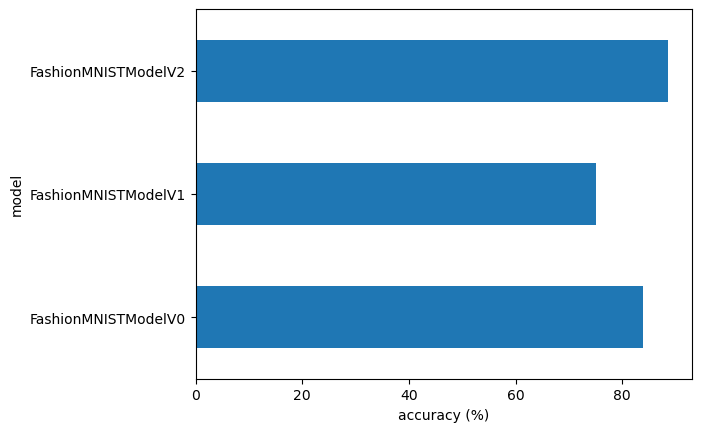

In [273]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

### 9. Make and evaluate random predictions with best model

In [276]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device=device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model output raw logits)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())

        # Stack the pred_probs to turn list into a tensor
        return torch.stack(pred_probs)

In [314]:
import random
#random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Pullover')

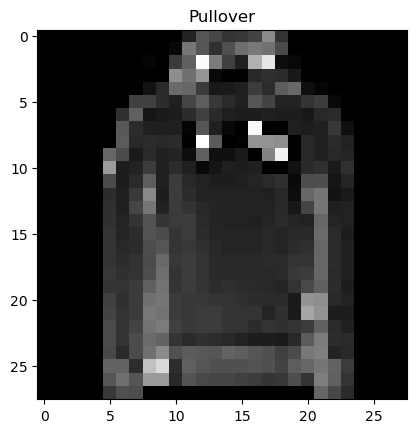

In [315]:
plt.imshow(test_samples[0].squeeze(),cmap="gray")
plt.title(class_name[test_labels[0]])

In [316]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View first two prediction probabilities
pred_probs[:2]

tensor([[1.1332e-03, 3.7087e-05, 5.2051e-01, 1.9003e-04, 4.7476e-01, 5.1745e-06,
         2.3519e-03, 5.7228e-06, 9.4795e-04, 5.3613e-05],
        [9.5235e-07, 9.5430e-07, 3.0033e-02, 8.4080e-07, 9.6957e-01, 4.5037e-09,
         3.8176e-04, 2.2266e-08, 1.4824e-05, 8.7417e-07]])

In [317]:
# Convert prediction probabillities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes, test_labels

(tensor([2, 4, 4, 3, 2, 2, 0, 1, 1]), [2, 4, 6, 3, 2, 2, 0, 1, 1])

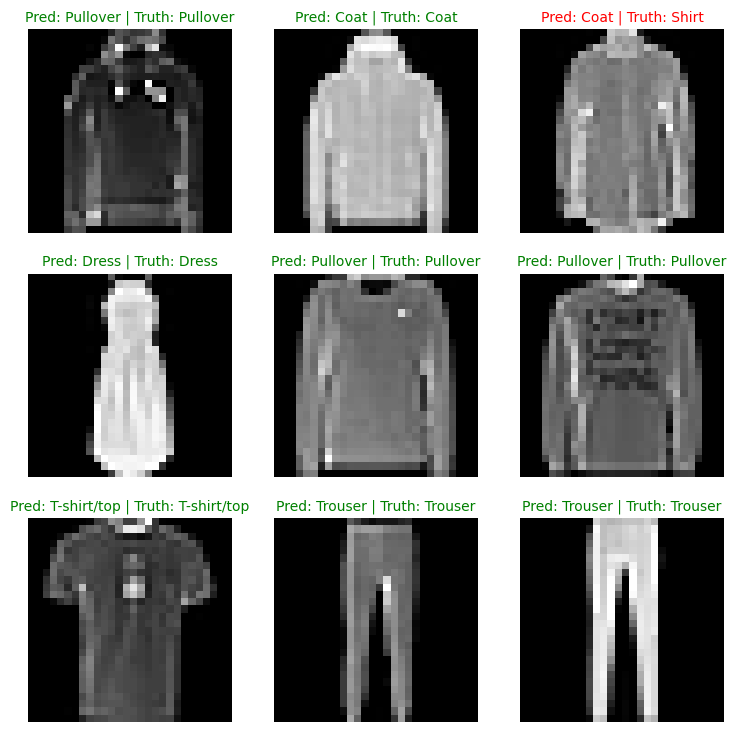

In [318]:
# Plot predictions
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction (in text form e.g " Sandal")
    pred_label = class_name[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = class_name[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green test if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r") 

    plt.axis(False)

### 10. Making a confusion matrix for further prediction evaluation

A confusion matrix is a fantastic way of evaluating your classification models visually.

1. Make prediction with our trained madel on the test dataset.
2. Make a confusion matrix `torchmetrics.ConfusionMatrix`.
3. Plot the cnfusion matrix using `mlxtend.plotting.plot_confusion_matrix()`.

In [322]:
# Import tqdm.auto
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        # Send the data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model_2(X)
        # Turn predictions from logits -prediction probabilities -> prediction labels
        y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
#print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 0, 0])

In [361]:
# See if required packages are installed and if not, install them...
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, ("mlxtend version should be 0.19.0 or higher")
except:
    print("error")
    !conda install torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [362]:
import mlxtend
print(mlxtend.__version__)

0.22.0


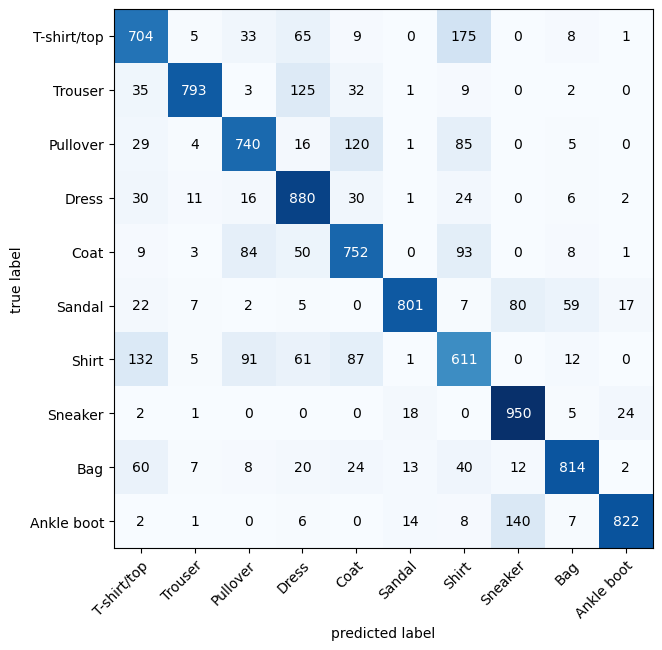

In [389]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task = "multiclass",
                          num_classes=len(class_name))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes to work with numpy
    figsize=(10,7),
    class_names= class_name
)


### 11. Save and load best performing model

In [394]:
from pathlib import Path

# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\03_pytorch_computer_vision_model_2.pth


In [397]:
# Create a new instance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))

# Load in the save state_dice()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [398]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32179442048072815,
 'model_acc': 88.54832268370608}

In [402]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32179442048072815,
 'model_acc': 88.54832268370608}

In [407]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
             atol=1e-02) # tolerence level

tensor(True)